In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
from sqlalchemy.orm import sessionmaker
import os, sys
from enum import Enum
from functools import partial
from collections import defaultdict
from typing import List, Any, Optional, Tuple

project_dir = os.path.abspath('..')
sys.path.insert(0, project_dir)

from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal

import yaml

import unittest
from unittest.mock import patch
from volatility_forecast.data.dataloader import (
    TiingoEoDDataLoader,
    PriceVolumeDatabaseLoader,
    TiingoEodDataLoaderProd,
)
from volatility_forecast.data.datamanager import (
    ReturnDataManager,
    LagReturnDataManager,
    LagAbsReturnDataManager, 
    LagSquareReturnDataManager,
    SquareReturnDataManager,
)
from volatility_forecast.data.date_util import get_closest_next_business_day, get_closest_prev_business_day
from volatility_forecast.data.base import Field, DataSet, DateLike
from volatility_forecast.data.dataset import PriceVolume
from volatility_forecast.data.persistence import persist_data, load_data_from_db
from volatility_forecast.data.database import engine, Base

from volatility_forecast.model.stes_model import STESModel
from volatility_forecast.model.xgboost_stes_model import XGBoostSTESModel, DEFAULT_XGBOOST_PARAMS

from volatility_forecast.evaluation.model_evaluator import evaluate_model, compare_models, root_mean_squared_error, generate_model_forecasts


In [2]:
ModelName = Enum(
    "ModelName", "ES STES_AE STES_SE STES_ESE STES_EAE STES_AESE STES_EAESE XGBoost_STES"
)

In [9]:
tickers = ("SPY", )
start_date = "2000-01-01"
end_date = pd.Timestamp.today() - pd.Timedelta(days=1)

In [10]:
ReturnDataManager().get_data(tickers, start_date, end_date)

(array([[-0.00983544],
        [-0.03989133],
        [ 0.00178731],
        ...,
        [ 0.01692052],
        [-0.00172566],
        [ 0.00249578]]),
 DatetimeIndex(['1999-12-31 00:00:00+00:00', '2000-01-03 00:00:00+00:00',
                '2000-01-04 00:00:00+00:00', '2000-01-05 00:00:00+00:00',
                '2000-01-06 00:00:00+00:00', '2000-01-07 00:00:00+00:00',
                '2000-01-10 00:00:00+00:00', '2000-01-11 00:00:00+00:00',
                '2000-01-12 00:00:00+00:00', '2000-01-13 00:00:00+00:00',
                ...
                '2024-09-10 00:00:00+00:00', '2024-09-11 00:00:00+00:00',
                '2024-09-12 00:00:00+00:00', '2024-09-13 00:00:00+00:00',
                '2024-09-16 00:00:00+00:00', '2024-09-17 00:00:00+00:00',
                '2024-09-18 00:00:00+00:00', '2024-09-19 00:00:00+00:00',
                '2024-09-20 00:00:00+00:00', '2024-09-23 00:00:00+00:00'],
               dtype='datetime64[ns, UTC]', name='date', length=6221, freq=None))

In [11]:
LagReturnDataManager().get_data(tickers, start_date, end_date)

(array([[ 0.00159723],
        [-0.00983544],
        [-0.03989133],
        ...,
        [-0.00297029],
        [ 0.01692052],
        [-0.00172566]]),
 DatetimeIndex(['1999-12-30 00:00:00+00:00', '1999-12-31 00:00:00+00:00',
                '2000-01-03 00:00:00+00:00', '2000-01-04 00:00:00+00:00',
                '2000-01-05 00:00:00+00:00', '2000-01-06 00:00:00+00:00',
                '2000-01-07 00:00:00+00:00', '2000-01-10 00:00:00+00:00',
                '2000-01-11 00:00:00+00:00', '2000-01-12 00:00:00+00:00',
                ...
                '2024-09-09 00:00:00+00:00', '2024-09-10 00:00:00+00:00',
                '2024-09-11 00:00:00+00:00', '2024-09-12 00:00:00+00:00',
                '2024-09-13 00:00:00+00:00', '2024-09-16 00:00:00+00:00',
                '2024-09-17 00:00:00+00:00', '2024-09-18 00:00:00+00:00',
                '2024-09-19 00:00:00+00:00', '2024-09-20 00:00:00+00:00'],
               dtype='datetime64[ns, UTC]', name='date', length=6221, freq=None))

In [12]:
def equity_data_provider(tickers: Tuple[str], start_date: DateLike, end_date: DateLike, model_name: ModelName) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    returns_data, returns_date = LagReturnDataManager().get_data(tickers, start_date, end_date)
    returns = returns_data * 1e2
    realized_var = SquareReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e4
    feature_sets = np.hstack([
        LagReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e2,
        LagAbsReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e2,
        LagSquareReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e4,
    ])
    if model_name == ModelName.ES:
        return np.ones((len(returns), 1)), realized_var, returns, returns_date
    elif model_name == ModelName.STES_AE:
        return np.hstack([np.ones((len(returns), 1)), feature_sets[:, [1]], ]), realized_var, returns, returns_date
    elif model_name == ModelName.STES_SE:
        return np.hstack([np.ones((len(returns), 1)), feature_sets[:, [2]], ]), realized_var, returns, returns_date
    elif model_name == ModelName.STES_EAE:
        return np.hstack([np.ones((len(returns), 1)), feature_sets[:, [0, 1]], ]), realized_var, returns, returns_date
    elif model_name == ModelName.STES_ESE:
        return np.hstack([np.ones((len(returns), 1)), feature_sets[:, [0, 2]], ]), realized_var, returns, returns_date
    elif model_name == ModelName.STES_AESE:
        return np.hstack([np.ones((len(returns), 1)), feature_sets[:, [1, 2]], ]), realized_var, returns, returns_date
    elif model_name == ModelName.STES_EAESE:
        return np.hstack([np.ones((len(returns), 1)), feature_sets, ]), realized_var, returns, returns_date
    elif model_name == ModelName.XGBoost_STES:
        return feature_sets, realized_var, returns, returns_date
    else:
        raise ValueError(f"Unknown model name: {model_name}")


In [13]:
spy_models = {m: STESModel() if m != ModelName.XGBoost_STES else XGBoostSTESModel(**DEFAULT_XGBOOST_PARAMS) for m in ModelName}

In [14]:
spy_results = {}
spy_var_pred = {}
for model_name in ModelName:
    np.random.seed(0)

    model = spy_models[model_name]
    data_provider = partial(
        equity_data_provider, 
        tickers=tickers, 
        start_date=start_date, 
        end_date=end_date, 
        model_name=model_name
    )

    os_res, is_res, y_pred, y = evaluate_model(
        data_provider,
        model, 
        root_mean_squared_error,
        10, 4000
    )
    spy_results[model_name] = (os_res, is_res)
    spy_var_pred[model_name] = y_pred


<Axes: xlabel='date'>

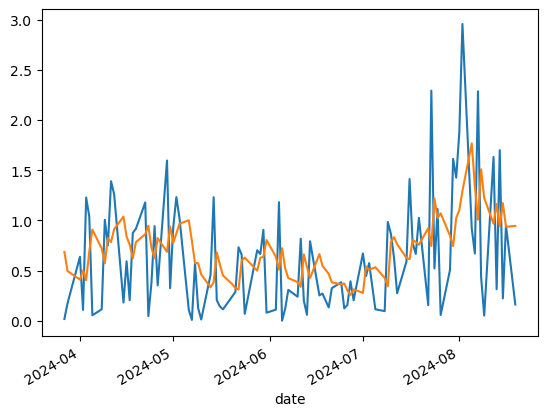

In [ ]:
np.sqrt(y).tail(100).plot()
np.sqrt(y_pred).tail(100).plot()


In [15]:
np.sqrt(y_pred).tail(10) * np.sqrt(252)

date
2024-09-09 00:00:00+00:00    16.951347
2024-09-10 00:00:00+00:00    14.055005
2024-09-11 00:00:00+00:00    15.339998
2024-09-12 00:00:00+00:00    14.198323
2024-09-13 00:00:00+00:00    12.316400
2024-09-16 00:00:00+00:00     9.845172
2024-09-17 00:00:00+00:00     7.133777
2024-09-18 00:00:00+00:00     6.373594
2024-09-19 00:00:00+00:00    14.366975
2024-09-20 00:00:00+00:00    11.625064
dtype: float32

In [16]:
np.sqrt(y).tail(10) * np.sqrt(252)

date
2024-09-09 00:00:00+00:00     6.899450
2024-09-10 00:00:00+00:00    16.202582
2024-09-11 00:00:00+00:00    13.315442
2024-09-12 00:00:00+00:00     8.269319
2024-09-13 00:00:00+00:00     2.342685
2024-09-16 00:00:00+00:00     0.648566
2024-09-17 00:00:00+00:00     4.715190
2024-09-18 00:00:00+00:00    26.860491
2024-09-19 00:00:00+00:00     2.739404
2024-09-20 00:00:00+00:00     3.961933
dtype: float64

# Test Data and Model Creation from Config

In [17]:
import yaml

with open('../config/model_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

print(config)


{'models': [{'name': 'ES', 'model_type': 'STESModel', 'features': []}, {'name': 'STES-E&AE&SE', 'model_type': 'STESModel', 'features': ['LagReturn', 'LagAbsReturn', 'LagSquaredReturn']}, {'name': 'STES-E&AE', 'model_type': 'STESModel', 'features': ['LagReturn', 'LagAbsReturn']}, {'name': 'XGBoost-STES', 'model_type': 'XGBoostSTESModel', 'features': ['LagReturn', 'LagSquaredReturn', 'LagAbsReturn'], 'params': {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'reg: squared error'}}], 'evaluation': {'test_size': 0.2, 'random_state': 42}, 'scheduler': {'daily_task_time': '00:05', 'recalibration_day': 'sun'}}


In [21]:
import yaml
import importlib
from typing import List, Dict, Any, Tuple
from functools import partial
from volatility_forecast.model import STESModel, XGBoostSTESModel
from volatility_forecast.data import (
    LagReturnDataManager, 
    LagAbsReturnDataManager,
    LagSquareReturnDataManager,
    LagAbsReturnDataManager
)

def load_config(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

def get_data_manager(feature: str):
    data_managers = {
        'LagReturn': LagReturnDataManager,
        'LagAbsReturn': LagAbsReturnDataManager,
        'LagSquaredReturn': LagSquareReturnDataManager,
    }
    return data_managers.get(feature, lambda: None)()

def create_feature_df(feature_list: List[str], tickers: List[str], start_date: str, end_date: str):
    return {
        feature: get_data_manager(feature).get_data(tickers, start_date, end_date)[0]
        for feature in feature_list
    }

def create_model(model_config: Dict[str, Any], feature_data: Dict[str, Any]):
    model_type = model_config['model_type']
    module_name, class_name = model_type.rsplit('.', 1)
    module = importlib.import_module(module_name)
    model_class = getattr(module, class_name)
    
    features = {k: v for k, v in feature_data.items() if k in model_config['features']}
    
    if 'params' in model_config:
        return model_class(**model_config['params'])
    else:
        return model_class()

def create_models_from_config() -> List[Tuple[str, Any]]:
    model_config = load_config('../config/model_config.yaml')
    data_config = load_config('../config/data_config.yaml')['data']
    
    # Debugging: Print the loaded configuration
    print("Loaded model_config:", model_config)
    print("Loaded data_config:", data_config)
    
    if 'models' not in model_config or model_config['models'] is None:
        raise ValueError("The 'models' key is missing or None in the model_config.yaml file")
    
    feature_list = set()
    for model in model_config['models']:
        if 'features' in model:
            feature_list.update(model['features'])
    
    feature_data = create_feature_df(
        list(feature_list),
        tuple(data_config['tickers']),
        data_config['start_date'],
        data_config['end_date']
    )
    
    return [
        (model['name'], create_model(model, feature_data))
        for model in model_config['models']
    ]

# Create models
models = create_models_from_config()

# Print created models
for name, model in models:
    print(f"Created model: {name}, Type: {type(model).__name__}")




Loaded model_config: {'models': [{'name': 'ES', 'model_type': 'volatility_forecast.model.stes_model.STESModel', 'features': []}, {'name': 'STES-E&AE&SE', 'model_type': 'volatility_forecast.model.stes_model.STESModel', 'features': ['LagReturn', 'LagAbsReturn', 'LagSquaredReturn']}, {'name': 'STES-E&AE', 'model_type': 'volatility_forecast.model.stes_model.STESModel', 'features': ['LagReturn', 'LagAbsReturn']}, {'name': 'XGBoost-STES', 'model_type': 'volatility_forecast.model.xgboost_stes_model.XGBoostSTESModel', 'features': ['LagReturn', 'LagSquaredReturn', 'LagAbsReturn'], 'params': {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'reg: squared error'}}], 'evaluation': {'test_size': 0.2, 'random_state': 42}, 'scheduler': {'daily_task_time': '00:05', 'recalibration_day': 'sun'}}
Loaded data_config: {'tickers': ['SPY'], 'start_date': '2000-01-01', 'end_date': '2023-12-31'}


TypeError: XGBoostSTESModel.__init__() takes 1 positional argument but 2 were given

In [11]:
model_config['models']

NameError: name 'model_config' is not defined

In [18]:
LagReturnDataManager().get_data(('SPY', ), "2020-01-01", "2021-12-31")

TypeError: Cannot compare tz-naive and tz-aware datetime-like objects